In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_csv('Housing.csv')
df.head()
df.replace({'yes': 1, 'no': 0, 'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2}, inplace=True)
M=len(df)
M

545

In [3]:
GPU_cuda_no = 0

cuda_no = 'cuda:'+str(GPU_cuda_no)

device = torch.device(cuda_no if torch.cuda.is_available() else 'cpu')

In [4]:
X_4 = df[['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'mainroad', 'guestroom','basement', 'hotwaterheating', 'airconditioning','prefarea', 'furnishingstatus']]
y = df[['price']]

In [5]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y, test_size=0.2, random_state=42)

In [6]:
scaler = StandardScaler()
X_train_4 = scaler.fit_transform(X_train_4)
X_test_4 = scaler.transform(X_test_4)

In [7]:
if isinstance(X_train_4, pd.DataFrame):
    X_train_4 = X_train_4.values
if isinstance(X_test_4, pd.DataFrame):
    X_test_4 = X_test_4.values
if isinstance(y_train_4, pd.DataFrame):
    y_train_4 = y_train_4.values
if isinstance(y_test_4, pd.DataFrame):
    y_test_4 = y_test_4.values

In [8]:
X_train_4 = torch.tensor(X_train_4, dtype=torch.float32)
y_train_4 = torch.tensor(y_train_4, dtype=torch.float32).view(-1, 1)
X_test_4 = torch.tensor(X_test_4, dtype=torch.float32)
y_test_4 = torch.tensor(y_test_4, dtype=torch.float32).view(-1, 1)

In [9]:
class neuralNetworkOneLayer(nn.Module):
    def __init__(self):
        super(neuralNetworkOneLayer, self).__init__()
        self.fc1 = nn.Linear(12, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
learning_rate = 0.001

In [11]:
OneLayer = neuralNetworkOneLayer().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(OneLayer.parameters(), lr=learning_rate)

In [12]:
train_dataset = TensorDataset(X_train_4, y_train_4)
val_dataset = TensorDataset(X_test_4, y_test_4)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
train_losses = []
val_losses = []

In [14]:
epochs = 5000
for epoch in range(epochs):
    OneLayer.train()
    running_loss = 0.0
    for X_train_4, y_train_4 in train_loader:
        optimizer.zero_grad()
        outputs = OneLayer(X_train_4)
        loss = criterion(outputs, y_train_4)
        mape = torch.mean(torch.abs((y_train_4 - outputs) / y_train_4)) * 100
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_train_4.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    OneLayer.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_train_4, y_train_4 in val_loader:
            predicted = OneLayer(X_test_4)
            test_loss = criterion(predicted, y_test_4)
            running_val_loss += loss.item() * X_train_4.size(0)
    val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    mape = torch.mean(torch.abs((y_test_4 - predicted) / y_test_4)) * 100

print(f'Test MAPE: {mape.item():.2f}%')
print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, mape:{mape.item():.4f}')


Test MAPE: 93.82%
Epoch [5000/5000], Loss: 20918279871534.9727, Val Loss: 16410220691456.0000, mape:93.8221


In [15]:
num_params_nn = sum(p.numel() for p in OneLayer.parameters() if p.requires_grad)

In [16]:
num_params_nn

449

In [17]:
class neuralNetworkThreeLayer(nn.Module):
    def __init__(self):
        super(neuralNetworkThreeLayer, self).__init__()
        self.fc1 = nn.Linear(12, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [18]:
ThreeLayer = neuralNetworkThreeLayer().to(device)
optimizer = optim.Adam(ThreeLayer.parameters(), lr=0.01)

In [19]:
epochs = 5000
for epoch in range(epochs):
    ThreeLayer.train()
    running_loss = 0.0
    for X_train_4, y_train_4 in train_loader:
        optimizer.zero_grad()
        outputs = ThreeLayer(X_train_4)
        loss = criterion(outputs, y_train_4)
        mape = torch.mean(torch.abs((y_train_4 - outputs) / y_train_4)) * 100
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_train_4.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    ThreeLayer.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_train_4, y_train_4 in val_loader:
            predicted = ThreeLayer(X_test_4)
            test_loss = criterion(predicted, y_test_4)
            running_val_loss += loss.item() * X_train_4.size(0)
    val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    mape = torch.mean(torch.abs((y_test_4 - predicted) / y_test_4)) * 100
    
print(f'Test MAPE: {mape.item():.2f}%')
print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, mape:{mape.item():.4f}')


Test MAPE: 30.02%
Epoch [5000/5000], Loss: 95890702486.3119, Val Loss: 81257644032.0000, mape:30.0175


In [20]:
num_params_nn = sum(p.numel() for p in ThreeLayer.parameters() if p.requires_grad)

In [21]:
num_params_nn

3585

In [22]:
import torchvision
import torchvision.transforms as transforms
import time

In [23]:
epochs = 10
batch_size = 100


In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [25]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
class CIFAR10OneLayer(nn.Module):
    def __init__(self):
        super(CIFAR10OneLayer, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
CIFOneLayer = CIFAR10OneLayer().to(device)

In [29]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(CIFOneLayer.parameters(), lr=learning_rate)

In [30]:
total_step = len(train_loader)
start_time = time.time()

In [31]:
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = CIFOneLayer(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [100/500], Loss: 1.9811
Epoch [1/10], Step [200/500], Loss: 1.6928
Epoch [1/10], Step [300/500], Loss: 1.6260
Epoch [1/10], Step [400/500], Loss: 1.6300
Epoch [1/10], Step [500/500], Loss: 1.5290
Epoch [2/10], Step [100/500], Loss: 1.6209
Epoch [2/10], Step [200/500], Loss: 1.3559
Epoch [2/10], Step [300/500], Loss: 1.4677
Epoch [2/10], Step [400/500], Loss: 1.6519
Epoch [2/10], Step [500/500], Loss: 1.3417
Epoch [3/10], Step [100/500], Loss: 1.3499
Epoch [3/10], Step [200/500], Loss: 1.4312
Epoch [3/10], Step [300/500], Loss: 1.4431
Epoch [3/10], Step [400/500], Loss: 1.2785
Epoch [3/10], Step [500/500], Loss: 1.3705
Epoch [4/10], Step [100/500], Loss: 1.3856
Epoch [4/10], Step [200/500], Loss: 1.3706
Epoch [4/10], Step [300/500], Loss: 1.2990
Epoch [4/10], Step [400/500], Loss: 1.3402
Epoch [4/10], Step [500/500], Loss: 1.5565
Epoch [5/10], Step [100/500], Loss: 1.1710
Epoch [5/10], Step [200/500], Loss: 1.3391
Epoch [5/10], Step [300/500], Loss: 1.1614
Epoch [5/10

In [32]:
training_time = time.time() - start_time
print(f'Training time: {training_time:.2f} seconds')

Training time: 87.40 seconds


In [33]:
CIFOneLayer.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images #.to(device)
        labels = labels #.to(device)
        outputs = CIFOneLayer(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    train_loss = 0
    for images, labels in train_loader:
        images = images #.to(device)
        labels = labels #.to(device)
        outputs = CIFOneLayer(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f'Training Loss: {train_loss:.4f}')

Test Accuracy: 49.94%
Training Loss: 0.9670


In [34]:
import matplotlib.pyplot as plt

In [35]:
epoches = 300
class CIFAR10ThreeLayer(nn.Module):
    def __init__(self):
        super(CIFAR10ThreeLayer, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [36]:
CIFThreeLayer = CIFAR10ThreeLayer().to(device)

In [37]:
optimizer = optim.Adam(CIFThreeLayer.parameters(), lr=learning_rate)
train_losses = []
test_losses = []

In [38]:
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = CIFThreeLayer(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    CIFThreeLayer.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = CIFThreeLayer(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
        
    if (i+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [500/500], Loss: 1.4994
Epoch [2/10], Step [500/500], Loss: 1.4057
Epoch [3/10], Step [500/500], Loss: 1.4391
Epoch [4/10], Step [500/500], Loss: 1.4078
Epoch [5/10], Step [500/500], Loss: 1.4568
Epoch [6/10], Step [500/500], Loss: 1.2532
Epoch [7/10], Step [500/500], Loss: 1.4606
Epoch [8/10], Step [500/500], Loss: 1.5316
Epoch [9/10], Step [500/500], Loss: 1.4440
Epoch [10/10], Step [500/500], Loss: 1.5279


In [39]:
training_time = time.time() - start_time
print(f'Training time: {training_time:.2f} seconds')

Training time: 203.63 seconds


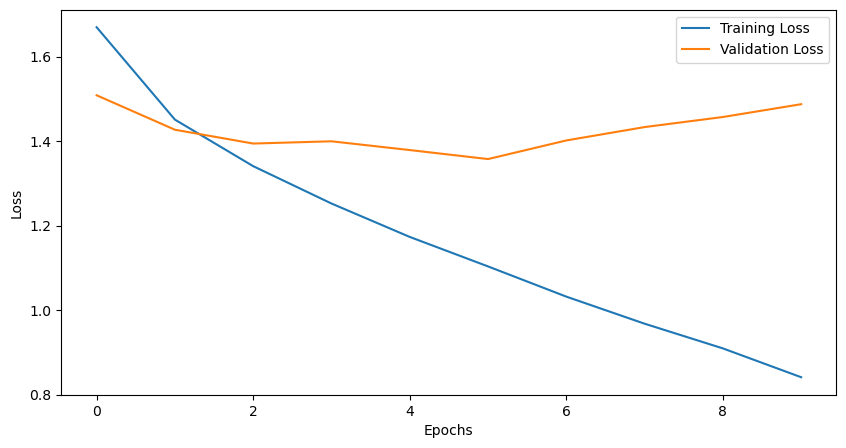

In [40]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
CIFThreeLayer.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = CIFThreeLayer(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = CIFThreeLayer(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f'Training Loss: {train_loss:.4f}')

Test Accuracy: 54.04%
Training Loss: 0.7297


In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [43]:
params_one_layer = count_parameters(CIFOneLayer)
params_three_layers = count_parameters(CIFThreeLayer)

In [44]:
print(f'Number of parameters in the one hidden layer model: {params_one_layer}')
print(f'Number of parameters in the three hidden layers model: {params_three_layers}')

Number of parameters in the one hidden layer model: 1578506
Number of parameters in the three hidden layers model: 1738890
